Предварительно про PyTorch:
* [Про тензоры в pytorch](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/tensor_tutorial.ipynb)
* [Про автоматическое дифференцирование и что такое .backwards()](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/autograd_tutorial.ipynb)
* [Очень простая нейронка на pytorch](https://colab.research.google.com/drive/1RsZvw4KBGn5U5Aj5Ak7OG2pHx6z1OSlF)

# Классификация текстов

Используя ноутбук занятия (также размещен в папке Materials) и данные fakenews, 3 раза разными способами получить на задаче классификации значение f1 выше 0.91 для методов на sklearn и выше 0.52 для методов на pytorch.

## Fakenews

1. Мы будем работать с данными fakenews отсюда: https://raw.githubusercontent.com/diptamath/covid_fake_news/main/data/Constraint_Train.csv
2. Проведите препроцессинг текста. Разбейте данные на train и test для задачи классификации.
3. Векторизуйте.
4. Обучите на полученных векторах алгоритм классификации.

Мы уже видели как эта задача выполняется с помощью Word2vec. Давайте вспомним.

In [ ]:
!wget https://raw.githubusercontent.com/diptamath/covid_fake_news/main/data/Constraint_Train.csv

--2024-11-05 16:02:06--  https://raw.githubusercontent.com/diptamath/covid_fake_news/main/data/Constraint_Train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1253562 (1.2M) [text/plain]
Saving to: ‘Constraint_Train.csv’

Constraint_Train.cs 100%[===================>]   1.20M  --.-KB/s    in 0.09s   

2024-11-05 16:02:06 (14.0 MB/s) - ‘Constraint_Train.csv’ saved [1253562/1253562]



In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('Constraint_Train.csv')

In [ ]:
df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


<Axes: ylabel='count'>

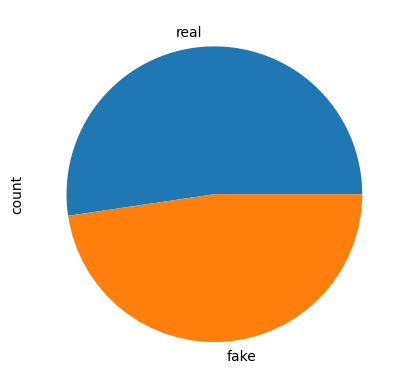

In [ ]:
df["label"].value_counts().plot.pie()

In [ ]:
from nltk.tokenize import word_tokenize
from tqdm import tqdm

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
sentences = [word_tokenize(text.lower()) for text in tqdm(df.tweet)]

100%|██████████| 6420/6420 [00:03<00:00, 2062.61it/s]


In [ ]:
from gensim.models.word2vec import Word2Vec
%time model_tweets = Word2Vec(sentences, workers=4, vector_size = 300, min_count=3, window=5, epochs = 15)

CPU times: user 7.99 s, sys: 184 ms, total: 8.17 s
Wall time: 8.71 s


In [ ]:
model_tweets.wv.most_similar('france')

[('floor', 0.9261847734451294),
 ('2015', 0.9158944487571716),
 ('corpses', 0.9130887985229492),
 ('front', 0.9130111932754517),
 ('protesting', 0.9099985957145691),
 ('singing', 0.9051418304443359),
 ('bags', 0.9023224115371704),
 ('gain', 0.8964864611625671),
 ('center', 0.8928209543228149),
 ('road', 0.8910912871360779)]

In [ ]:
model_tweets.init_sims()

<ipython-input-11-f1a8336e4a1e>:1: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model_tweets.init_sims()


In [ ]:
import numpy as np

In [ ]:
def get_text_embedding(text):
    result = []
    for word in word_tokenize(text.lower()):
        if word in model_tweets.wv:
            result.append(model_tweets.wv[word])

    if len(result):
        result = np.sum(result, axis=0)
    else:
        result = np.zeros(300)
    return result

In [ ]:
features = [get_text_embedding(text) for text in tqdm(df.tweet)]

100%|██████████| 6420/6420 [00:06<00:00, 1017.27it/s]


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(features, df.label, test_size=0.33)

In [ ]:
model = LogisticRegression()
model.fit(X_train_w2v, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
predicted = model.predict(X_test_w2v)

In [ ]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

        fake       0.91      0.92      0.91      1009
        real       0.92      0.91      0.92      1110

    accuracy                           0.91      2119
   macro avg       0.91      0.91      0.91      2119
weighted avg       0.91      0.91      0.91      2119



In [ ]:
# попробуем подобрать параметр регуляризации для логистической регресии, используя gridsearchcv

In [ ]:
gridsearch_lg = GridSearchCV(LogisticRegression(max_iter = 5000, random_state = 454),
                             param_grid = {"C": [0.01, 0.1, 1, 10, 100]}, cv = 5, verbose = 2)

In [ ]:
gridsearch_lg.fit(X_train_w2v, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .............................................C=0.01; total time=   1.0s
[CV] END .............................................C=0.01; total time=   1.4s
[CV] END .............................................C=0.01; total time=   1.0s
[CV] END .............................................C=0.01; total time=   1.0s
[CV] END .............................................C=0.01; total time=   0.7s
[CV] END ..............................................C=0.1; total time=   1.1s
[CV] END ..............................................C=0.1; total time=   1.0s
[CV] END ..............................................C=0.1; total time=   2.6s
[CV] END ..............................................C=0.1; total time=   2.7s
[CV] END ..............................................C=0.1; total time=   1.6s
[CV] END ................................................C=1; total time=   2.6s
[CV] END ........................................

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................................C=100; total time=   6.1s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................................C=100; total time=   7.9s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................................C=100; total time=   6.4s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................................C=100; total time=   8.5s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ..............................................C=100; total time=   6.2s


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=5000, random_state=454),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]}, verbose=2)

In [ ]:
gridsearch_lg.best_score_

0.9274577965048753

In [ ]:
gridsearch_lg.best_params_

{'C': 10}

In [ ]:
y_pred_gs_lg = gridsearch_lg.predict(X_test_w2v)

In [ ]:
print(classification_report(y_pred_gs_lg, y_test))

              precision    recall  f1-score   support

        fake       0.93      0.91      0.92      1026
        real       0.92      0.93      0.93      1093

    accuracy                           0.92      2119
   macro avg       0.92      0.92      0.92      2119
weighted avg       0.92      0.92      0.92      2119



In [ ]:
# попробуем использоавть метод опорных векторов

from sklearn.svm import SVC

In [ ]:
gridsearch_svc = GridSearchCV(SVC(max_iter = 10000, random_state = 454),
                             param_grid = {"C": [0.01, 0.1, 1, 10, 100, 200]}, cv = 5, verbose = 2)

In [ ]:
gridsearch_svc.fit(X_train_w2v, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .............................................C=0.01; total time=   2.4s
[CV] END .............................................C=0.01; total time=   1.9s
[CV] END .............................................C=0.01; total time=   2.0s
[CV] END .............................................C=0.01; total time=   1.8s
[CV] END .............................................C=0.01; total time=   1.9s
[CV] END ..............................................C=0.1; total time=   1.1s
[CV] END ..............................................C=0.1; total time=   1.3s
[CV] END ..............................................C=0.1; total time=   1.5s
[CV] END ..............................................C=0.1; total time=   1.5s
[CV] END ..............................................C=0.1; total time=   1.2s
[CV] END ................................................C=1; total time=   0.8s
[CV] END ........................................

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ..............................................C=100; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ..............................................C=100; total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ..............................................C=100; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ..............................................C=100; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ..............................................C=100; total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ..............................................C=200; total time=   0.9s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ..............................................C=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ..............................................C=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ..............................................C=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV] END ..............................................C=200; total time=   0.7s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


GridSearchCV(cv=5, estimator=SVC(max_iter=10000, random_state=454),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 200]}, verbose=2)

In [ ]:
gridsearch_svc.best_score_

0.9402447127461308

In [ ]:
gridsearch_svc.best_params_

{'C': 100}

In [ ]:
y_pred_gs_svc = gridsearch_svc.predict(X_test_w2v)

In [ ]:
print(classification_report(y_pred_gs_svc, y_test))

              precision    recall  f1-score   support

        fake       0.93      0.94      0.94      1002
        real       0.95      0.94      0.94      1117

    accuracy                           0.94      2119
   macro avg       0.94      0.94      0.94      2119
weighted avg       0.94      0.94      0.94      2119



###  Что будет, если использовать самый наивный метод?

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vec = CountVectorizer()

In [ ]:
bow = vec.fit_transform(df.tweet)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, df.label, test_size=0.33)
model = LogisticRegression()
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
predicted = model.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

        fake       0.92      0.92      0.92      1053
        real       0.92      0.92      0.92      1066

    accuracy                           0.92      2119
   macro avg       0.92      0.92      0.92      2119
weighted avg       0.92      0.92      0.92      2119



Для методов из классического машинного обучения лучшим из опробованных нами является метод опорных векторов с подбором гиперпараметров.

Конечно, мы всегда можем поиграться с предобработкой.

### PyTorch + LSTM

In [ ]:
labels = (df.label == 'real').astype(int).to_list()

Нужно заранее задать размер для макксимальной длины предложений.

In [ ]:
token_lists = [word_tokenize(text.lower()) for text in df.tweet]
max_len = len(max(token_lists, key=len))

In [ ]:
max_len

1592

Это слишком много. Но какая длина обычно?

In [ ]:
from collections import Counter
fd = Counter([len(tokens) for tokens in token_lists])

In [ ]:
fd.most_common(10)

[(20, 178),
 (25, 174),
 (22, 170),
 (18, 170),
 (19, 168),
 (21, 168),
 (16, 163),
 (17, 162),
 (15, 160),
 (23, 156)]

Зададим максимум 200.

Возьмём те же w2v эмбеддинги.

In [ ]:
def get_word_embedding(tokens, max_len):
    result = []
    for i in range(max_len):
        if i < len(tokens):
            word = tokens[i]
            if word in model_tweets.wv:
                result.append(model_tweets.wv[word])
            else:
                result.append(np.zeros(300))
        else:
            result.append(np.zeros(300))
    return result

In [ ]:
features = [get_word_embedding(text, 200) for text in tqdm(token_lists)]

100%|██████████| 6420/6420 [00:02<00:00, 2500.88it/s]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
len(features[0][0])

300

In [ ]:
len(X_train)

4301

In [ ]:
len(X_train[0])

200

In [ ]:
len(X_train[0][0])

300

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(300, 100)
        self.out = nn.Linear(100, 1)

    def forward(self, x):
        embeddings, (shortterm, longterm) = self.lstm(x.transpose(0, 1))
        prediction = torch.sigmoid(self.out(longterm))
        return prediction


net = Net()
print(net)

Net(
  (lstm): LSTM(300, 100)
  (out): Linear(in_features=100, out_features=1, bias=True)
)


In [ ]:
in_data = torch.tensor(X_train).float()
targets = torch.tensor(y_train).float()

<ipython-input-54-02003c1debcb>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  in_data = torch.tensor(X_train).float()


In [ ]:
in_data.shape

torch.Size([4301, 200, 300])

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [ ]:
criterion = criterion.to(device)
net = net.to(device)

In [ ]:
def train_one_epoch(in_data, targets, batch_size=16):
    for i in tqdm(range(0, in_data.shape[0], batch_size)):
        batch_x = in_data[i:i + batch_size]
        batch_y = targets[i:i + batch_size]
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = net(batch_x)
        loss = criterion(output.reshape(-1), batch_y)
        loss.backward()
        optimizer.step()
    print(loss)

In [ ]:
train_one_epoch(in_data, targets)

100%|██████████| 269/269 [00:01<00:00, 163.05it/s]


tensor(0.6784, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


Что получилось?

In [ ]:
in_data_test = torch.tensor(X_test).float().to(device)
targets_test = torch.tensor(y_test).float().to(device)

In [ ]:
with torch.no_grad():
    output = net(in_data_test).reshape(-1)

In [ ]:
result = (output.cpu() > 0.5) == targets_test.cpu()

In [ ]:
result.sum().item() / len(result)

0.5276073619631901

Но такую модель надо учить дольше(

In [ ]:
class SentimentRNN(nn.Module):
    def __init__(self, no_layers, hidden_dim, embedding_dim):
        super(SentimentRNN,self).__init__()

        self.hidden_dim = hidden_dim

        self.no_layers = no_layers

        #lstm
        self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        batch_size = x.size(0)

        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(x)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out

net_2 = SentimentRNN(2, 256, 300)
print(net_2)

SentimentRNN(
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
optimizer = optim.Adam(net_2.parameters(), lr = 0.01)
criterion = nn.BCELoss()

In [ ]:
criterion = criterion.to(device)
net_2 = net_2.to(device)

In [ ]:
def train_one_epoch(in_data, targets, batch_size = 64):
    net_2.train()
    for i in tqdm(range(0, in_data.shape[0], batch_size)):
        batch_x = in_data[i:i + batch_size]
        batch_y = targets[i:i + batch_size]
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()
        output = net_2(batch_x)
        loss = criterion(output.reshape(-1), batch_y)
        loss.backward()
        optimizer.step()
    return loss.cpu().item()

In [ ]:
def test_one_epoch(in_data, targets, batch_size = 64):
    net_2.eval()
    for i in tqdm(range(0, in_data.shape[0], batch_size)):
        batch_x = in_data[i:i + batch_size]
        batch_y = targets[i:i + batch_size]
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        with torch.no_grad():
          output = net_2(batch_x)
          loss = criterion(output.reshape(-1), batch_y)
    return loss.cpu().item()

In [ ]:
n_epochs = 20

In [ ]:
train_losses = []
test_losses = []

In [ ]:
for i in range(n_epochs):
  train_loss = train_one_epoch(in_data, targets)
  test_loss = test_one_epoch(in_data_test, targets_test)
  print(f"эпоха - {i+1}, train_loss = {train_loss}, test_loss = {test_loss}")
  train_losses.append(train_loss)
  test_losses.append(test_loss)

100%|██████████| 34/34 [00:00<00:00, 78.86it/s]


эпоха - 1, train_loss = 0.3329795002937317, test_loss = 0.6387641429901123


100%|██████████| 34/34 [00:00<00:00, 78.37it/s]


эпоха - 2, train_loss = 0.205871120095253, test_loss = 0.7235376238822937


100%|██████████| 34/34 [00:00<00:00, 79.63it/s]


эпоха - 3, train_loss = 0.2039829045534134, test_loss = 0.6735740900039673


100%|██████████| 34/34 [00:00<00:00, 79.13it/s]


эпоха - 4, train_loss = 0.27237239480018616, test_loss = 0.7519372701644897


100%|██████████| 34/34 [00:00<00:00, 77.25it/s]


эпоха - 5, train_loss = 0.1518959254026413, test_loss = 0.7047322988510132


100%|██████████| 34/34 [00:00<00:00, 77.03it/s]


эпоха - 6, train_loss = 0.2579081654548645, test_loss = 0.5787727236747742


100%|██████████| 34/34 [00:00<00:00, 77.37it/s]


эпоха - 7, train_loss = 0.19802148640155792, test_loss = 0.6816233992576599


100%|██████████| 34/34 [00:00<00:00, 78.11it/s]


эпоха - 8, train_loss = 0.2664443850517273, test_loss = 0.6790701150894165


100%|██████████| 34/34 [00:00<00:00, 78.87it/s]


эпоха - 9, train_loss = 0.30546900629997253, test_loss = 0.6046202182769775


100%|██████████| 34/34 [00:00<00:00, 76.83it/s]


эпоха - 10, train_loss = 0.22599290311336517, test_loss = 0.6238365173339844


100%|██████████| 34/34 [00:00<00:00, 76.41it/s]


эпоха - 11, train_loss = 0.1412970870733261, test_loss = 0.7122161984443665


100%|██████████| 34/34 [00:00<00:00, 76.85it/s]


эпоха - 12, train_loss = 0.1357664316892624, test_loss = 0.7588460445404053


100%|██████████| 34/34 [00:00<00:00, 75.83it/s]


эпоха - 13, train_loss = 0.14864510297775269, test_loss = 0.6699411869049072


100%|██████████| 34/34 [00:00<00:00, 76.19it/s]


эпоха - 14, train_loss = 0.15238383412361145, test_loss = 0.6279491186141968


100%|██████████| 34/34 [00:00<00:00, 77.68it/s]


эпоха - 15, train_loss = 0.2373277246952057, test_loss = 0.7265886068344116


100%|██████████| 34/34 [00:00<00:00, 77.64it/s]


эпоха - 16, train_loss = 0.09273561835289001, test_loss = 0.7889019846916199


100%|██████████| 34/34 [00:00<00:00, 78.08it/s]


эпоха - 17, train_loss = 0.07704678922891617, test_loss = 0.5916599035263062


100%|██████████| 34/34 [00:00<00:00, 75.81it/s]


эпоха - 18, train_loss = 0.11103588342666626, test_loss = 0.6740128993988037


100%|██████████| 34/34 [00:00<00:00, 77.42it/s]


эпоха - 19, train_loss = 0.12164061516523361, test_loss = 0.7037028074264526


100%|██████████| 34/34 [00:00<00:00, 76.87it/s]

эпоха - 20, train_loss = 0.11096861213445663, test_loss = 0.577573299407959


In [ ]:
with torch.no_grad():
    output = net_2(in_data_test).reshape(-1)

In [ ]:
result = (output.cpu() > 0.5) == targets_test.cpu()

In [ ]:
result.sum().item() / len(result)

0.8853232656913639

Для метода pytorch удалось добиться результата 88%. Благодаря использованию двух слоев lstm и увеличенному числу нейронов во внутреннем полносвязном слое.